2021/12/4

This code is for stiching multiple FLM images.

In high magnification image of softwood species, image registration based on SIFT doesnt perform well beacuse of their structural similarities.

In stead of SIFT, image refistration is conducted by phase only correlation (POC) method implemented in opencv (cv2.phaseCorrelate).

In [1]:
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
import os, sys
from common.Stitcher import Stitcher
from tqdm import tqdm
from skimage.filters import threshold_otsu

Set path

In [2]:
current_path=os.getcwd()
flm_path=os.path.join(current_path, "FLM")
species=os.listdir(flm_path)

npz_path=os.path.join(current_path, "npz_file")
if os.path.exists(npz_path)==False:
    os.makedirs(npz_path)
    
fig_save_path=os.path.join(current_path, "fig_save", "concatenation_result")
if os.path.exists(fig_save_path)==False:
    os.makedirs(fig_save_path)

Load flm images (x10)

In [3]:
#find pathes to flm images

for i, (root, dirs, files) in enumerate(os.walk(flm_path)):
    if len(files)>0:
        flm_im_path=[os.path.join(root, files[j]) for j in range(len(files))]
        flm_im_path=[j for j in flm_im_path if ".tif" in j]
        flm_im_path_list_UV=[j for j in flm_im_path if "UV" in j]
        flm_im_path_list_G=[j for j in flm_im_path if "G" in j]
        
#load images
#UV image
flm_list_UV=[]
flm_binary_list_UV=[]
flm_b_list_UV=[]

for flm_im_path in tqdm(flm_im_path_list_UV):
    im=cv2.imread(flm_im_path, -1)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    #binarization
    threshold = threshold_otsu(im[:,:,2])
    img=np.where(im[:,:,2]<threshold, 255, 0)
    
    flm_list_UV.append(im)
    flm_b_list_UV.append(im[:,:,2])
    flm_binary_list_UV.append(img)


#gree-light excitation
flm_list_G=[]
flm_binary_list_G=[]
flm_r_list_G=[]

for flm_im_path in tqdm(flm_im_path_list_G):
    im=cv2.imread(flm_im_path, -1)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    #binarization
    threshold = threshold_otsu(im[:,:,0])
    img=np.where(im[:,:,0]<threshold, 255, 0)
    
    flm_list_G.append(im)
    flm_r_list_G.append(im[:,:,0])
    flm_binary_list_G.append(img)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


In [4]:
#image set as the forst input is imposed to position adjustment, and the second is the template
stitcher=Stitcher()

result_list=[]
result_list_UV=[]
result_list_G=[]
result_list_b=[]
result_list_r=[]
for i in tqdm(range(2)):
    target_im_binary_list=flm_binary_list_UV[i*len(flm_binary_list_UV)//2:(i+1)*len(flm_binary_list_UV)//2]
    target_im_b_list=flm_b_list_UV[i*len(flm_b_list_UV)//2:(i+1)*len(flm_b_list_UV)//2]
    target_im_r_list=flm_r_list_G[i*len(flm_r_list_G)//2:(i+1)*len(flm_r_list_G)//2]
    target_im_UV_list=flm_list_UV[i*len(flm_list_UV)//2:(i+1)*len(flm_list_UV)//2]
    target_im_G_list=flm_list_G[i*len(flm_list_G)//2:(i+1)*len(flm_list_G)//2]
    
    #POC
    img_criterion, img_UV=stitcher.POC_reference_criterion(target_im_binary_list, target_im_UV_list)
    _, img_G=stitcher.POC_reference_criterion(target_im_binary_list, target_im_G_list)
    _, img_b=stitcher.POC_reference_criterion(target_im_binary_list, target_im_b_list)
    _, img_r=stitcher.POC_reference_criterion(target_im_binary_list, target_im_r_list)
    
    #save results
    result_list.append(img_criterion)
    result_list_UV.append(img_UV)
    result_list_G.append(img_G)
    result_list_b.append(img_b)
    result_list_r.append(img_r)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:31<00:00, 15.73s/it]


In [6]:
#Finally, image registration of upper and bottom part is conducted
image_criterion=stitcher.image_dimension_adj(result_list[0], result_list[1], padding=0, criterion="A")
image_b=stitcher.image_dimension_adj(result_list_b[0], result_list_b[1], padding=0, criterion="A")
image_r=stitcher.image_dimension_adj(result_list_r[0], result_list_r[1], padding=0, criterion="A")
image_UV=stitcher.image_dimension_adj_3D(result_list_UV[0], result_list_UV[1], padding=0, criterion="A")
image_G=stitcher.image_dimension_adj_3D(result_list_G[0], result_list_G[1], padding=0, criterion="A")

#POC
img_result_criterion, img_result_UV=stitcher.POC_reference_criterion(image_criterion, image_UV)
_, img_result_G=stitcher.POC_reference_criterion(image_criterion, image_G)
_, img_result_b=stitcher.POC_reference_criterion(image_criterion, image_b)
_, img_result_r=stitcher.POC_reference_criterion(image_criterion, image_r)

criterion=A
imageA: height=3276, width=5112
imageB: height=3273, width=4974
After adjustment, imageA: height=3276, width=5112
After adjustment, imageB: height=3276, width=5112
criterion=A
imageA: height=3276, width=5112
imageB: height=3273, width=4974
After adjustment, imageA: height=3276, width=5112
After adjustment, imageB: height=3276, width=5112
criterion=A
imageA: height=3276, width=5112
imageB: height=3273, width=4974
After adjustment, imageA: height=3276, width=5112
After adjustment, imageB: height=3276, width=5112
criterion=A
imageA: height=3276, width=5112
imageB: height=3273, width=4974
After adjustment, imageA: height=3276, width=5112
After adjustment, imageB: height=3276, width=5112
criterion=A
imageA: height=3276, width=5112
imageB: height=3273, width=4974
After adjustment, imageA: height=3276, width=5112
After adjustment, imageB: height=3276, width=5112


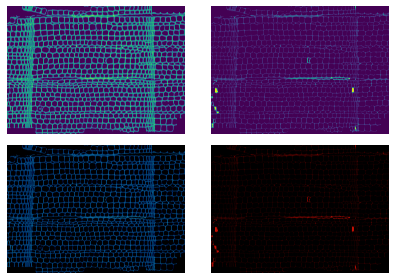

In [10]:
#show result
fig, ax=plt.subplots(2, 2, figsize=(6, 4))
ax[0, 0].imshow(img_result_b)
ax[0, 0].axis("off")
ax[0, 0].invert_xaxis()

ax[0, 1].imshow(img_result_r)
ax[0, 1].axis("off")
ax[0, 1].invert_xaxis()

ax[1, 0].imshow(img_result_UV)
ax[1, 0].axis("off")
ax[1, 0].invert_xaxis()

ax[1, 1].imshow(img_result_G)
ax[1, 1].axis("off")
ax[1, 1].invert_xaxis()
plt.tight_layout()
plt.show()
plt.close()

In [11]:
#save result
np.savez_compressed(os.path.join(npz_path, "flm_stiched_x10.npz"), im_stitch_b=img_result_b, im_stitch_r=img_result_r,  
                    im_stitch_ori_UV=img_result_UV, im_stitch_ori_G=img_result_G, im_stitch_binary=img_result_criterion)